# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ultralytics
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import copy
from tqdm import tqdm

# Dataset Overview

In [3]:
def plot_images(img_files, label_files):
    for idx in range(10):
        img_file = img_files[idx]
        img = cv2.imread(img_file)
        
        
        img_h, img_w = img.shape[0], img.shape[1]
        label_file = label_files[idx]
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                bbox = line.strip().split(' ')
                
                x_center = float(bbox[1]) * img_w
                y_center = float(bbox[2]) * img_h
                w = float(bbox[3]) * img_w
                h = float(bbox[4]) * img_h
                
                x_min = int(x_center - w / 2)
                y_min = int(y_center - h / 2)
                x_max = int(x_center + w / 2)
                y_max = int(y_center + h / 2)
                
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=10)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        

In [4]:
def classify(file_path):
    img_files = []
    label_files = []
    for file in os.listdir(file_path):
        if file.split('.')[-1] == 'jpeg':
            img_files.append(os.path.join(file_path,file))
        elif file != 'count.txt':
            label_files.append(os.path.join(file_path,file))
    return sorted(img_files), sorted(label_files)

## Visual Images

In [5]:
visual_file_path = 'Dataset/210417_MtErie_Enterprise_VIS_0003'
VIS_img_files, VIS_label_files= classify(visual_file_path)

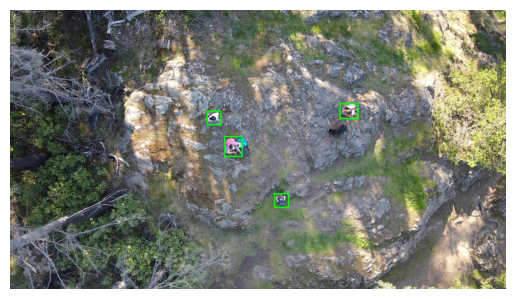

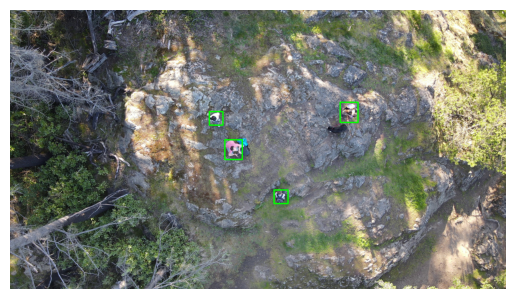

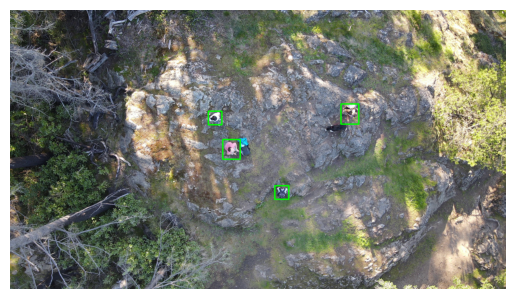

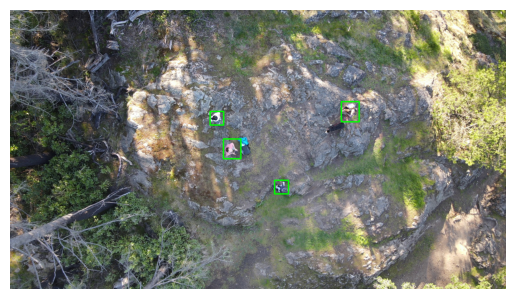

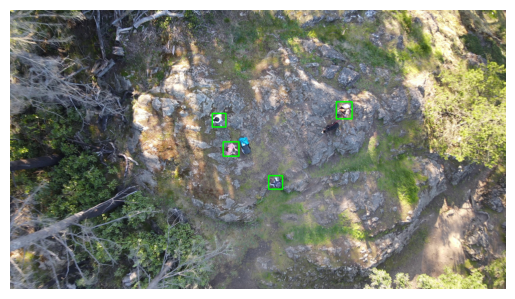

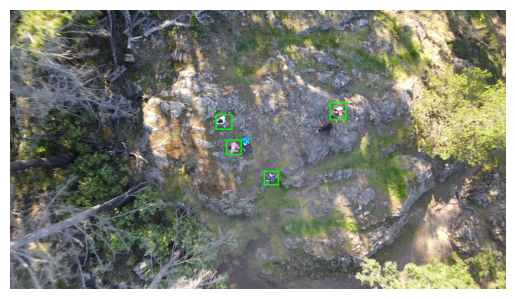

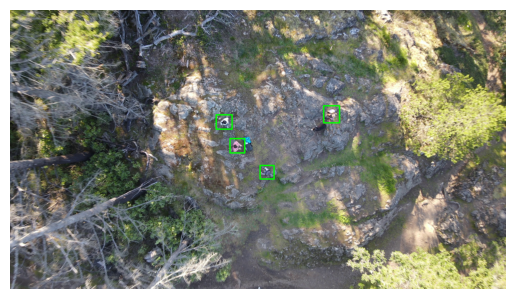

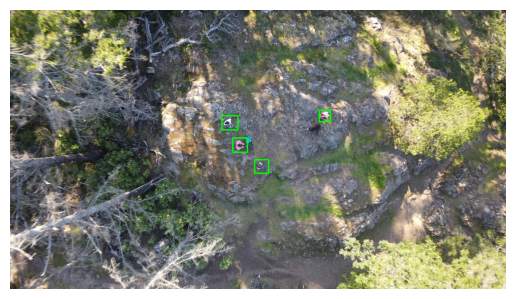

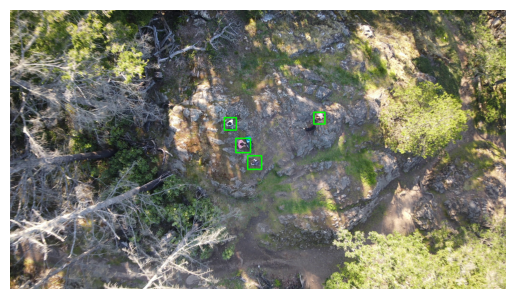

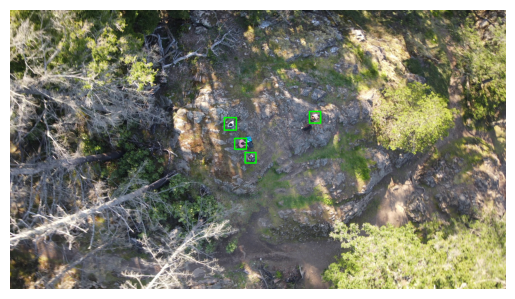

In [5]:
plot_images(VIS_img_files, VIS_label_files)

## Thermal Images

In [6]:
thermal_file_path = 'Dataset/210417_MtErie_Enterprise_IR_0004'
IR_img_files, IR_label_files= classify(thermal_file_path)

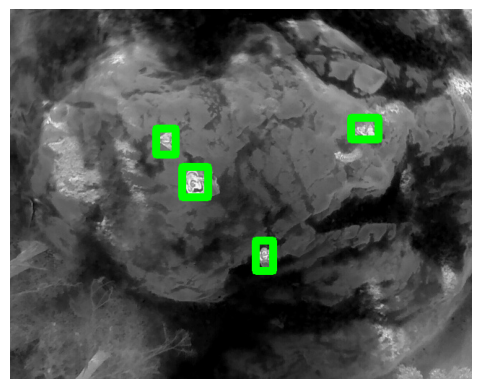

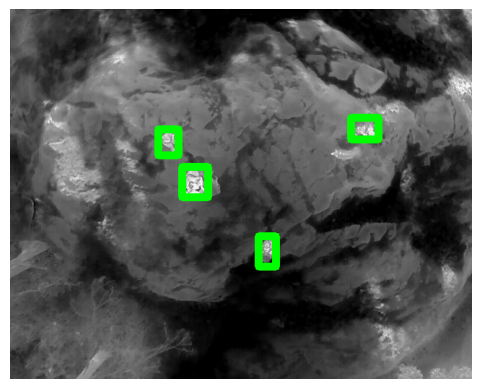

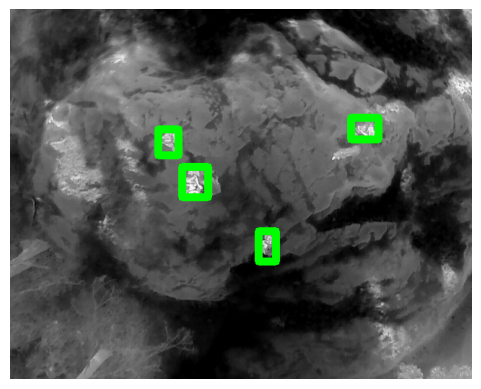

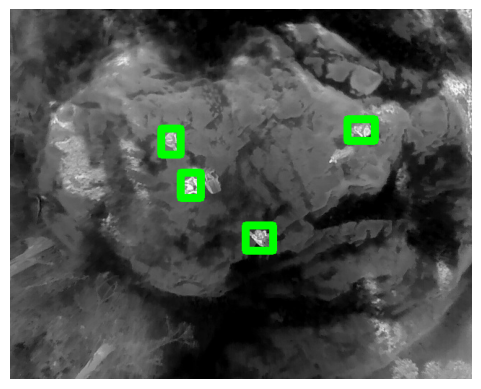

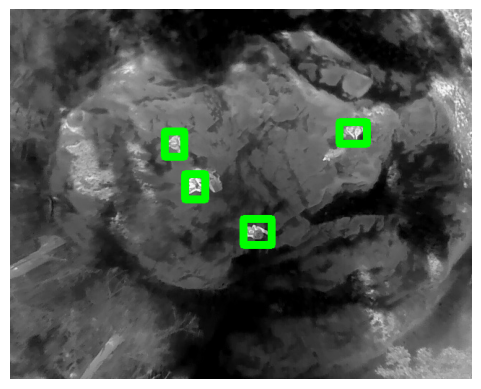

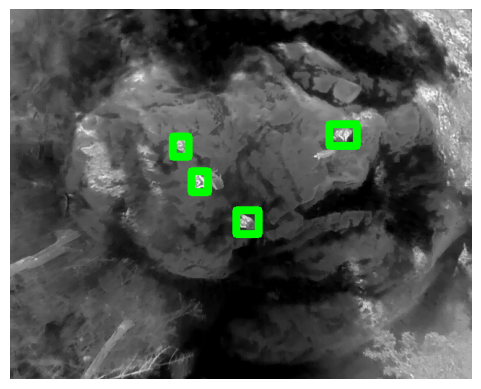

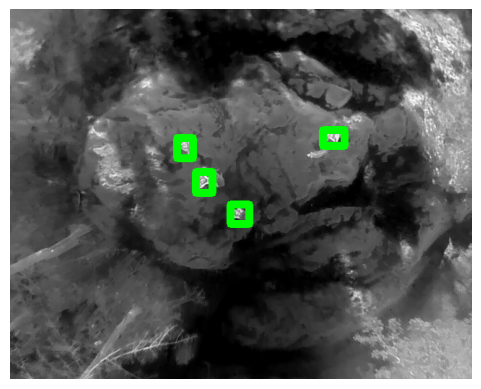

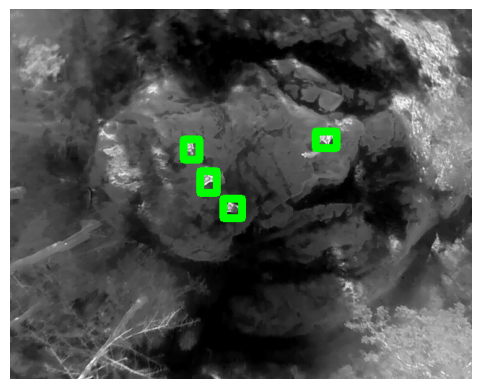

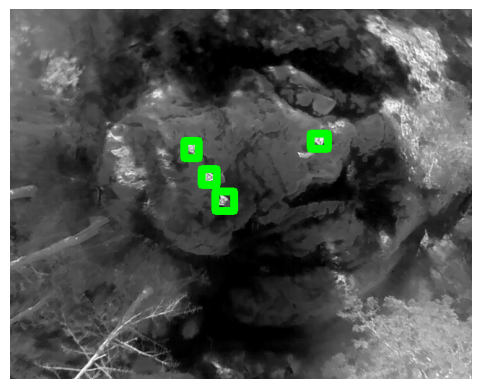

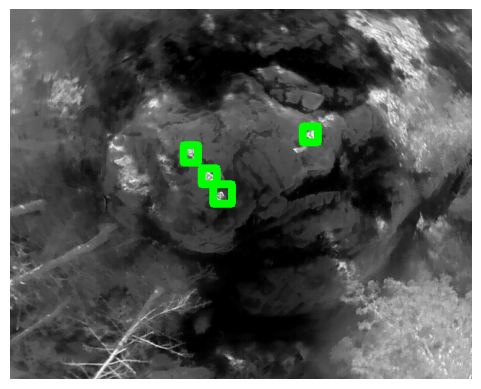

In [7]:
plot_images(IR_img_files, IR_label_files)

# Preprocessing

In [8]:
def standardization(img):
    pass

In [9]:
def augment_and_transform(img):
    pass

In [10]:
def filtering_and_smoothing(img):
    pass    

In [7]:
transform ={
    'train': transforms.Compose([
        # transforms.RandomHorizontalFlip(p=0.3),
        # transforms.ColorJitter(brightness=0.5, contrast=0.5,saturation=0.3),
        # transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.3,3.)),
        # transforms.RandomInvert(),
        # transforms.RandomCrop(size=(128,128)),
        # transforms.RandomRotation(degrees=(0,180)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=0, std=1)
    ]),
    'val': transforms.Compose([
        # transforms.RandomHorizontalFlip(p=0.5),
        # transforms.AutoAugment(),
        # transforms.RandomCrop(size=(128,128)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=0, std=1)
    ]),
    'test': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.AutoAugment(),
        # transforms.RandomCrop(size=(128,128)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=0, std=1)
    ])   
}

In [8]:
class Dataset(Dataset):
    def __init__(self, img_files, label_files, transform=None):
        self.img_files = img_files
        self.label_files= label_files
        self.transform= transform
        
    def __len__(self):
        return len(self.img_files)

    
    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        label_file = self.label_files[idx]
        
        img = Image.open(img_file).convert("RGB")
        img_w, img_h= img.size
        
        
        bboxes = self.extract_bbox(label_file, img_h,img_w)
        bboxes = torch.tensor(bboxes, dtype=torch.float32) if bboxes else torch.tensor(np.reshape(bboxes,(0,4)), dtype=torch.float32)
        labels = torch.ones(bboxes.shape[0], dtype=torch.int64)
        
        target = {"boxes": bboxes, "labels": labels}
        
        if self.transform:
            img = self.transform(img)
        
        return img, target
        
    def extract_bbox(self, label_file, img_h,img_w):
        bboxes=[]
        with open(label_file,'r') as f:
            lines= f.readlines()
            for line in lines:
                bbox = line.split(' ')
                x_center = float(bbox[1]) * img_w
                y_center = float(bbox[2]) * img_h
                w = float(bbox[3]) * img_w
                h = float(bbox[4]) * img_h
                
                x_min = int(x_center - w / 2)
                y_min = int(y_center - h / 2)
                x_max = int(x_center + w / 2)
                y_max = int(y_center + h / 2)
                bboxes.append([x_min,y_min,x_max,y_max])
        
        return bboxes
    
                

In [9]:
img_files = VIS_img_files + IR_img_files
labels =  VIS_label_files + IR_label_files

In [10]:
ds = Dataset(img_files, labels)

In [11]:
train_size = int(len(ds)*0.7)
val_size = len(ds)-train_size

train_ds, val_ds = random_split(ds, [train_size,val_size])

In [12]:
train_ds.dataset.transform = transform['train']
val_ds.dataset.transform= transform['val']


In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Modeling

In [15]:
model= torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

        

In [16]:
model.backbone.requires_grad_(False)

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

In [21]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

backbone.body.conv1.weight False
backbone.body.layer1.0.conv1.weight False
backbone.body.layer1.0.conv2.weight False
backbone.body.layer1.0.conv3.weight False
backbone.body.layer1.0.downsample.0.weight False
backbone.body.layer1.1.conv1.weight False
backbone.body.layer1.1.conv2.weight False
backbone.body.layer1.1.conv3.weight False
backbone.body.layer1.2.conv1.weight False
backbone.body.layer1.2.conv2.weight False
backbone.body.layer1.2.conv3.weight False
backbone.body.layer2.0.conv1.weight False
backbone.body.layer2.0.conv2.weight False
backbone.body.layer2.0.conv3.weight False
backbone.body.layer2.0.downsample.0.weight False
backbone.body.layer2.1.conv1.weight False
backbone.body.layer2.1.conv2.weight False
backbone.body.layer2.1.conv3.weight False
backbone.body.layer2.2.conv1.weight False
backbone.body.layer2.2.conv2.weight False
backbone.body.layer2.2.conv3.weight False
backbone.body.layer2.3.conv1.weight False
backbone.body.layer2.3.conv2.weight False
backbone.body.layer2.3.conv3.

In [22]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [17]:
model.rpn.head.cls_logits = nn.Conv2d(256,2,kernel_size=(1,1), stride=(1,1))

In [18]:
model.roi_heads.box_predictor.cls_score= nn.Linear(1024, 2)
model.roi_heads.box_predictor.bbox_pred= nn.Linear(1024,8)


In [19]:
device= 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5,  weight_decay=0.1)
lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=8, threshold=0.0001)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [21]:
best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

In [22]:
def eval(model, val_loader, device, current_lr, lr_scheduler):
    total_loss=[]
    with torch.no_grad():
        model.eval()
        for imgs, targets in val_loader:
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(imgs, labels)
            loss = sum( loss for loss in loss_dict.values())
            total_loss.append(loss)
            
    lr_scheduler.step(total_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if total_loss<best_validation_loss:
        best_validation_loss=total_loss
        best_weights=copy.deepcopy(model.state_dict())
    
    return total_loss
     
        
        
        

In [23]:
def train(model, train_loader, val_loader, optimizer, lr_scheduler, epochs, device):
    total_training_loss= []
    total_valid_loss=[]
    model.train()
    
    for epoch in range(epochs):
        epoch_loss=[]
        current_lr=get_lr(optimizer)
        for imgs, targets in train_loader:
            optimizer.zero_grad()
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(imgs, targets)
            losses=sum(loss for loss in loss_dict.values())
            epoch_loss.append(losses.item())
            losses.backward()    
            optimizer.step()
            
        total_training_loss(sum(epoch_loss))
        val_loss= eval(model, val_loader, device, current_lr, lr_scheduler)
        total_valid_loss.append(val_loss)
        print(f"Epoch {epoch+1} \nTraining Loss: {epoch_loss} \nValidation Loss: {val_loss}")
        print("*"*50)
    
    print(f"Average Training: {sum(total_training_loss)/len(total_training_loss)}")
    print(f"Average Validation: {sum(total_valid_loss)/len(total_valid_loss)}")

        
            
            
    

In [ ]:
train(model,train_loader, val_loader, optimizer, lr_scheduler, 1, device)
